In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
data = np.load('data.npy',allow_pickle=True) # data = [id, resnet, VIT, label, guess time]

# 2.2.1 - Plotting data

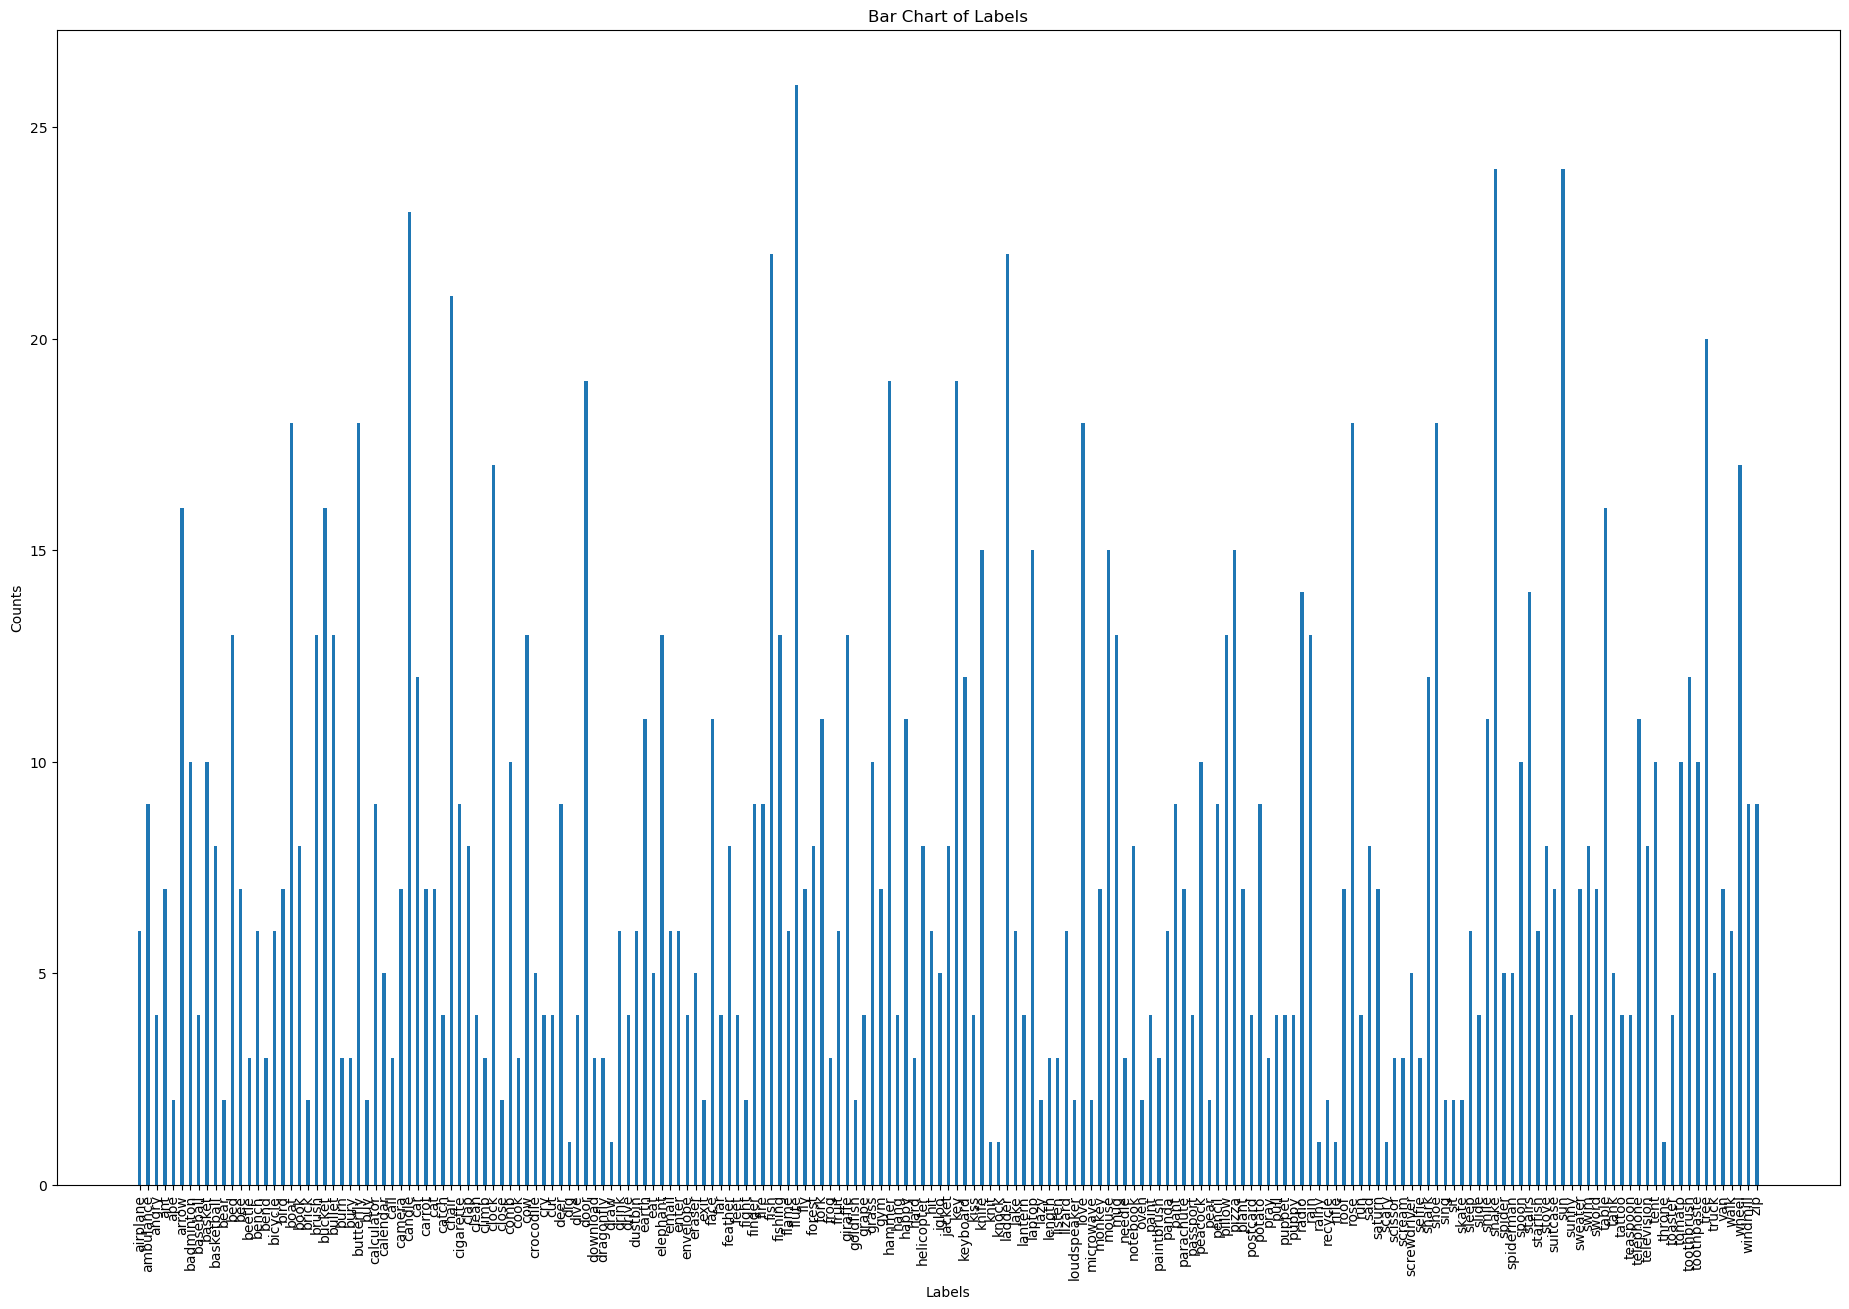

In [108]:
labels = data[:,3]
unique_labels, counts = np.unique(labels, return_counts=True) # return_counts=True: return the number of times each unique item appears in labels
# filter indices with counts > 10 for easy visualization
filtered_indices = counts > 0 # adjust this threshold
filtered_labels = unique_labels[filtered_indices]
filtered_counts = counts[filtered_indices]
# plot bar chart
plt.figure(figsize=(23,15)) # width, height
plt.bar(np.arange(len(filtered_labels)), filtered_counts, width=0.4)
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Bar Chart of Labels')
plt.xticks(np.arange(len(filtered_labels)), filtered_labels, rotation=90)
plt.show()

# 2.3.1 - KNN Implementation

In [111]:
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
split_index = int(0.80 * len(data))
class KNN:
    def __init__(self, k,metric,encoding=2):
        # train_data 
        train_data = data[:split_index]
        train_data_x = train_data[:, encoding]
        train_data_y = train_data[:, 3]
        train_data_x = np.array([x[0] for x in train_data_x]) 
        self.k = k
        self.data_X = train_data_x
        self.data_Y = train_data_y
        self.metric = metric
    
    def predict(self, X):
        y_pred = [self.predict_util(x) for x in X] # for each sample in X, predict its label
        return np.array(y_pred)
    
    def predict_util(self, x):

        # compute distances
        x = np.array(x).reshape(1,-1) # x is a single sample
        distances = []
        if(self.metric == "euclidean"):
            distances = np.sqrt(np.sum((self.data_X - x)**2, axis=1)) # axis=1: sum along the row
        elif(self.metric == "manhattan"):
            distances = np.sum(np.abs(self.data_X - x), axis=1) # axis=1: sum along the row
        elif(self.metric == "cosine"):
            distances = 1 - np.sum(self.data_X * x, axis=1) / (np.sqrt(np.sum(self.data_X ** 2, axis=1)) * np.sqrt(np.sum(x ** 2))) 
        # distances = cdist(x_train, x, metric=self.metric).flatten() # cdist is faster than the above three methods
        distances = np.array(distances)

        # get k nearest samples, labels
        k_indices = np.argsort(distances)[:self.k] 
        k_nearest_labels = [self.data_Y[k_indices],k_indices] # k_nearest_labels = [[label1, label2, ...], [index1, index2, ...]]
        k_nearest_labels = np.array(k_nearest_labels).T # transpose
        
        # get most common label
        most_common = Counter(k_nearest_labels[:,0]).most_common()
        most_common_array = np.array(most_common) # if there are more than one most common labels
        all_most_common = most_common_array[most_common_array[:, 1] == most_common_array[0, 1], 0] # get all most common labels
        
        # tie breaker
        weights = np.zeros(len(all_most_common))
        for i, (label, index) in enumerate(k_nearest_labels):
            a = str(label)
            b = int(index)
            if a in all_most_common:
                weights[np.where(all_most_common == a)[0]] += (1 + distances[b]) ** (-1) 
        max_weight_index = np.argmax(weights)

        return all_most_common[max_weight_index]

    def performance_data(self, y_true, y_pred):
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred,average='macro',zero_division=1)
        recall = recall_score(y_true, y_pred,average='macro',zero_division=1)
        f1 = f1_score(y_true, y_pred,average='macro')
        return accuracy, precision, recall, f1



# 2.4.1 - Hyperparameter Tuning

In [112]:
from math import sqrt
# performance_data
max_accuracy = 0
best_k = 0
best_endcoding = ""
max_pred_y = []
best_metric = ""
dictonary = {"euclidean": 1, "manhattan": 2, "cosine": 3}
encodings = ["Resnet","VIT"]
top_20 = []

# test_data
test_data = data[split_index:]
test_data_y = test_data[:, 3]
# search for best k, encoding and metric
for encode in range(1,len(encodings)+1):
    test_data_x = test_data[:, encode]
    test_data_x = np.array([x[0] for x in test_data_x])
    for x in range(1, int(sqrt(split_index))+1): 
        for met in dictonary:
            classifier = KNN(x, met,encode)
            pred_y = classifier.predict(test_data_x)
            curr_accuracy = classifier.performance_data(test_data_y, pred_y)[0]
            top_20.append((curr_accuracy*100, x, encodings[encode-1], met))
            # if curr_accuracy >= max_accuracy:
            #     max_accuracy = curr_accuracy
            #     best_k = x
            #     max_pred_y = pred_y
            #     best_endcoding = encode
            #     best_metric = met
top_20 = sorted(top_20, key=lambda x: x[0], reverse=True)

     Accuracy   K Encoding     Metric
0   31.333333  10      VIT  euclidean
1   31.000000   9      VIT  euclidean
2   30.666667   8      VIT  euclidean
3   30.333333   8      VIT  manhattan
4   30.333333   9      VIT  manhattan
5   30.000000   7      VIT  manhattan
6   30.000000  11      VIT  euclidean
7   30.000000  13      VIT  manhattan
8   30.000000  14      VIT  manhattan
9   30.000000  17      VIT  manhattan
10  29.666667   6      VIT  manhattan
11  29.666667   9      VIT     cosine
12  29.666667  10      VIT  manhattan
13  29.666667  11      VIT  manhattan
14  29.666667  14      VIT  euclidean
15  29.666667  15      VIT  manhattan
16  29.666667  18      VIT  manhattan
17  29.333333  12      VIT  euclidean
18  29.333333  15      VIT  euclidean
19  29.333333  19      VIT  euclidean


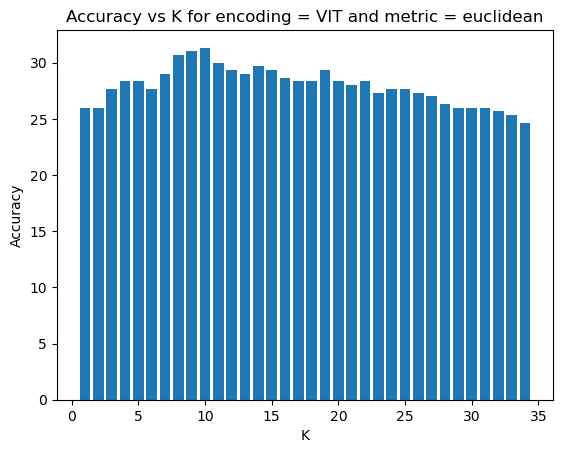

In [113]:
# accuracy vs k for encoding = VIT and metric = euclidean
x_values = [item[1] for item in top_20 if item[2] == "VIT" and item[3] == "euclidean"]
y_values = [item[0] for item in top_20 if item[2] == "VIT" and item[3] == "euclidean"]
plt.bar(x_values, y_values)
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.title("Accuracy vs K for encoding = VIT and metric = euclidean")
top_20 = top_20[:20]
print(pd.DataFrame(top_20, columns=["Accuracy", "K", "Encoding", "Metric"]))
best_k = top_20[0][1]
best_encoding = top_20[0][2]
best_metric = top_20[0][3]


# Creating 1.py

In [114]:
%%writefile 1.py
# convert a cell of 1.ipynb to 1.py
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss, confusion_matrix,classification_report
from math import sqrt

# Create an ArgumentParser object
parser = argparse.ArgumentParser(description="My script description")

# Add arguments
parser.add_argument("arg1", help="Description of arg1")

# Parse the arguments
args = parser.parse_args()

# Access the arguments using the args namespace
print("Path:", args.arg1)
data = np.load("data.npy",allow_pickle=True) # data = [id, resnet, VIT, label, guess time]
split_index = int(0.80 * len(data))
class KNN:
    def __init__(self, k,metric,encoding=2):
        # train_data 
        train_data = data[:split_index]
        train_data_x = train_data[:, encoding]
        train_data_y = train_data[:, 3]
        train_data_x = np.array([x[0] for x in train_data_x]) 
        self.k = k
        self.data_X = train_data_x
        self.data_Y = train_data_y
        self.metric = metric
    
    def predict(self, X):
        y_pred = [self.predict_util(x) for x in X] # for each sample in X, predict its label
        return np.array(y_pred)
    
    def predict_util(self, x):

        # compute distances
        x = np.array(x).reshape(1,-1)
        decision_tree_data_train_x = np.array(self.data_X)
        distances = []
        if(self.metric == "euclidean"):
            distances = np.sqrt(np.sum((self.data_X - x)**2, axis=1)) 
        elif(self.metric == "manhattan"):
            distances = np.sum(np.abs(self.data_X - x), axis=1)

        elif(self.metric == "cosine"):
            distances = 1 - np.sum(self.data_X * x, axis=1) / (np.sqrt(np.sum(self.data_X ** 2, axis=1)) * np.sqrt(np.sum(x ** 2))) 
        distances = np.array(distances)

        # get k nearest samples, labels
        k_indices = np.argsort(distances)[:self.k] 
        k_nearest_labels = [self.data_Y[k_indices],k_indices]
        k_nearest_labels = np.array(k_nearest_labels).T
        
        # get most common label
        most_common = Counter(k_nearest_labels[:,0]).most_common()
        most_common_array = np.array(most_common) # if there are more than one most common labels
        all_most_common = most_common_array[most_common_array[:, 1] == most_common_array[0, 1], 0] # get all most common labels
        
        # tie breaker
        weights = np.zeros(len(all_most_common))
        for i, (label, index) in enumerate(k_nearest_labels):
            a = str(label)
            b = int(index)
            if a in all_most_common:
                weights[np.where(all_most_common == a)[0]] += (1 + distances[b]) ** (-1) 
        max_weight_index = np.argmax(weights)

        return all_most_common[max_weight_index]

    def performance_data(self, y_true, y_pred):
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred,average='macro',zero_division=1)
        recall = recall_score(y_true, y_pred,average='macro',zero_division=1)
        f1 = f1_score(y_true, y_pred,average='macro')
        return accuracy, precision, recall, f1

# test_data
test_data = np.load(args.arg1,allow_pickle=True)
test_data_y = test_data[:, 3]

# max_accuracy = 0
# best_k = 0
# best_endcoding = ""
# max_pred_y = []
# best_metric = ""
# dictonary = {"euclidean": 1, "manhattan": 2, "cosine": 3}
# encodings = ["Resnet","VIT"]
# # search for best k, encoding and metric
# for encode in range(1,len(encodings)+1):
#     test_data_x = test_data[:, encode]
#     test_data_x = np.array([x[0] for x in test_data_x])
#     for x in range(1, int(sqrt(split_index))+1): 
#         for met in dictonary:
#             classifier = KNN(x, met,encode)
#             pred_y = classifier.predict(test_data_x)
#             curr_accuracy = classifier.performance_data(test_data_y, pred_y)[0]
#             if curr_accuracy >= max_accuracy:
#                 max_accuracy = curr_accuracy
#                 best_k = x
#                 max_pred_y = pred_y
#                 best_endcoding = encode
#                 best_metric = met
# print("best triplet:")
# print("K:", best_k)
# print("Encoding:", encodings[best_endcoding-1])
# print("Metric:", best_metric)
best_k = 10
best_metric = "euclidean"
best_endcoding = 2
classifier = KNN(best_k, best_metric,best_endcoding)
test_data_x = test_data[:, best_endcoding]
test_data_x = np.array([x[0] for x in test_data_x])
pred_y = classifier.predict(test_data_x)
performance = classifier.performance_data(test_data_y, pred_y)
print("Measures for best model:")

print(pd.DataFrame([performance], columns=["Accuracy", "Precision", "Recall", "F1-Score (macro)"]))


Overwriting 1.py


# 2.6 - Optimization

### The time complexity is approximatly O(N + Nlog(N)) for each sample in test set, where N is the size of Train set. The graph of the time complexity versus number of samples would continously increase as number of sample increases in the train set.


### Yes, it is possible to improve the execution time of the program by vectorization of the code with the help of numpy. Numpy improve the execution time by eliminating the use of for loops for individual elements.

### 1. `Broadcasting`: NumPy arrays allow for broadcasting, which is a set of rules for applying binary functions (e.g., addition, subtraction, multiplication, etc.) on arrays of different sizes.

### 2. `Use Built-in Functions`: NumPy has many built-in functions and optimized algorithms which can be used to perform complex calculations on entire arrays without the need for Python for loops.

### 3. `Parallelism`: Many vectorized operations can be parallelized, taking advantage of multiple cores in modern CPUs.

# My model v/s sklearn

Time taken by my model for best triplet: 0.17154216766357422
Time taken by sklearn for best triplet: 0.008617162704467773


<BarContainer object of 2 artists>

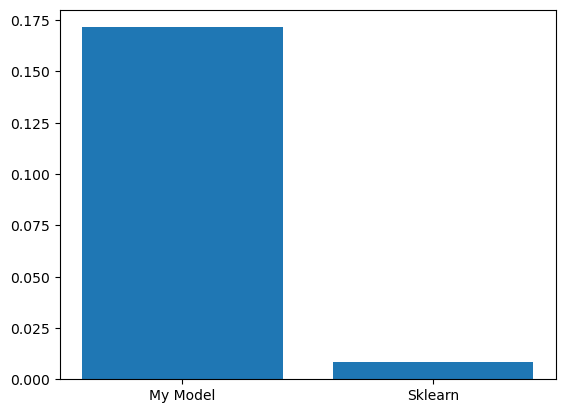

In [116]:
import time
from sklearn.neighbors import KNeighborsClassifier
# test_data
test_data = data[split_index:]
test_data_y = test_data[:, 3]
encode = 2
if(best_endcoding == "Resnet"):
    encode = 1
    test_data_x = test_data[:, 1]
    test_data_x = np.array([x[0] for x in test_data_x])
else:
    test_data_x = test_data[:, 2]
    test_data_x = np.array([x[0] for x in test_data_x])
start_time_my_model = time.time()
classifier = KNN(best_k, best_metric,encode)
pred_y = classifier.predict(test_data_x)
curr_accuracy = classifier.performance_data(test_data_y, pred_y)[0]
end_time_my_model = time.time()
start_time_sklearn = time.time()
X_VIT = [row[2][0] for row in test_data]
X_Resnet = [row[1][0] for row in test_data]
classifier = KNeighborsClassifier(n_neighbors=best_k,metric=best_metric)
if(best_endcoding == "Resnet"):
    classifier.fit(X_Resnet, test_data_y)
    pred_y = classifier.predict(X_Resnet)
else:
    classifier.fit(X_VIT, test_data_y)
    pred_y = classifier.predict(X_VIT)
curr_accuracy = accuracy_score(test_data_y, pred_y)
end_time_sklearn = time.time()
print("Time taken by my model for best triplet:", end_time_my_model - start_time_my_model)
print("Time taken by sklearn for best triplet:", end_time_sklearn - start_time_sklearn)
plt.bar(["My Model", "Sklearn"], [end_time_my_model - start_time_my_model, end_time_sklearn - start_time_sklearn])

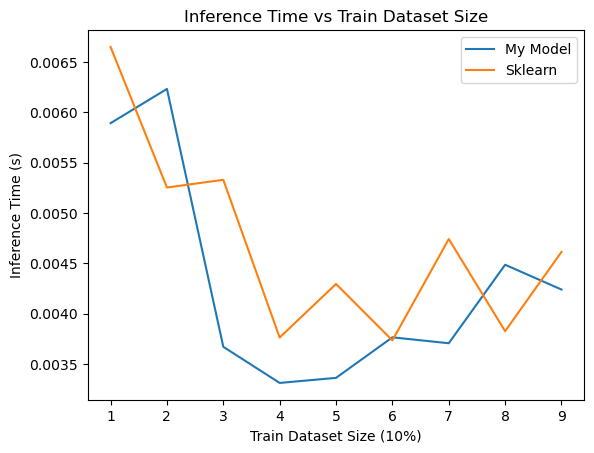

In [141]:
# plot the inference time vs train dataset size for my KNN model, and the default sklearn KNN model
import time
my_time = []
sklearn_time = []
X_VIT = [row[2][0] for row in test_data]
X_Resnet = [row[1][0] for row in test_data]
for i in range(1,10):
    split_index = int(i/10 * len(data))
    start_time_my_model = time.time()
    classifier = KNN(best_k, best_metric,encode)
    pred_y = classifier.predict(test_data_x)
    curr_accuracy = classifier.performance_data(test_data_y, pred_y)[0]
    end_time_my_model = time.time()
    start_time_sklearn = time.time()
    classifier = KNeighborsClassifier(n_neighbors=best_k,metric=best_metric)
    if(best_endcoding == "Resnet"):
        classifier.fit(X_Resnet, test_data_y)
        pred_y = classifier.predict(X_Resnet)
    else:
        classifier.fit(X_VIT, test_data_y)
        pred_y = classifier.predict(X_VIT)
    curr_accuracy = accuracy_score(test_data_y, pred_y)
    end_time_sklearn = time.time()
    my_time.append(end_time_my_model - start_time_my_model)
    sklearn_time.append(end_time_sklearn - start_time_sklearn)
plt.plot(np.arange(1,10), my_time, label="My Model")
plt.plot(np.arange(1,10), sklearn_time, label="Sklearn")
plt.xlabel("Train Dataset Size (10%)")
plt.ylabel("Inference Time (s)")
plt.title("Inference Time vs Train Dataset Size")
plt.legend()

# Data visualization

     age  gender        income    education  married  children           city  \
0     45    Male  61271.953359       Master    False         3    Lake Sheila   
1     24  Female  53229.101074  High School    False         1   Crystalburgh   
2     45  Female  30066.046684     Bachelor     True         3  Margaretburgh   
3     19    Male  48950.246384          PhD    False         0  Williamshaven   
4     29  Female  44792.627094       Master    False         0       New Paul   
..   ...     ...           ...          ...      ...       ...            ...   
995   61    Male  34246.773063       Master     True         3      Solisfurt   
996   56  Female  45494.225591     Bachelor    False         0    Dawsonmouth   
997   64  Female  68740.442006          PhD     True         0  Lake Garyport   
998   18  Female  44348.446680     Bachelor     True         0       Ericfurt   
999   61    Male  39160.083677       Master    False         0      Port Jose   

      occupation  purchase_

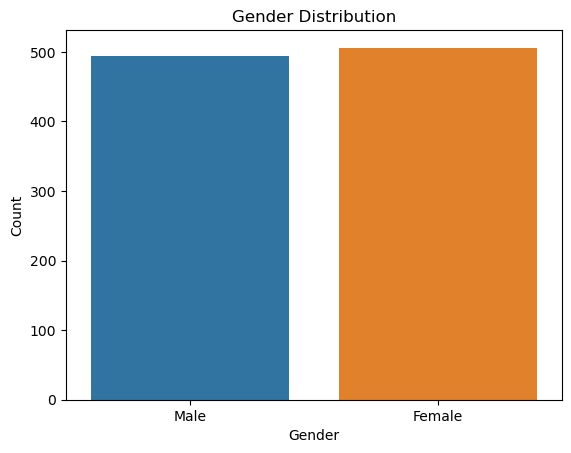

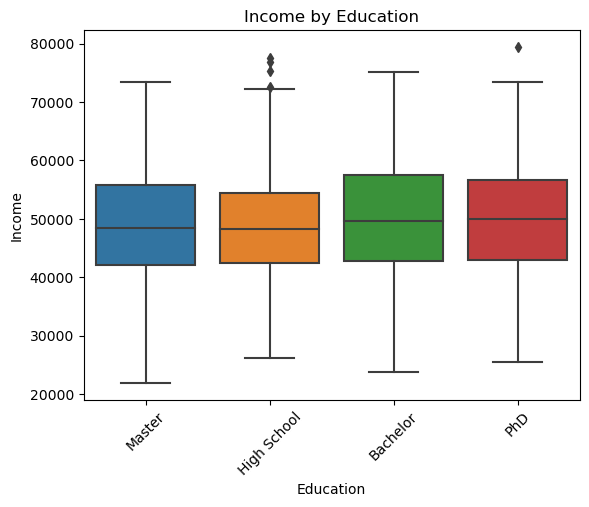

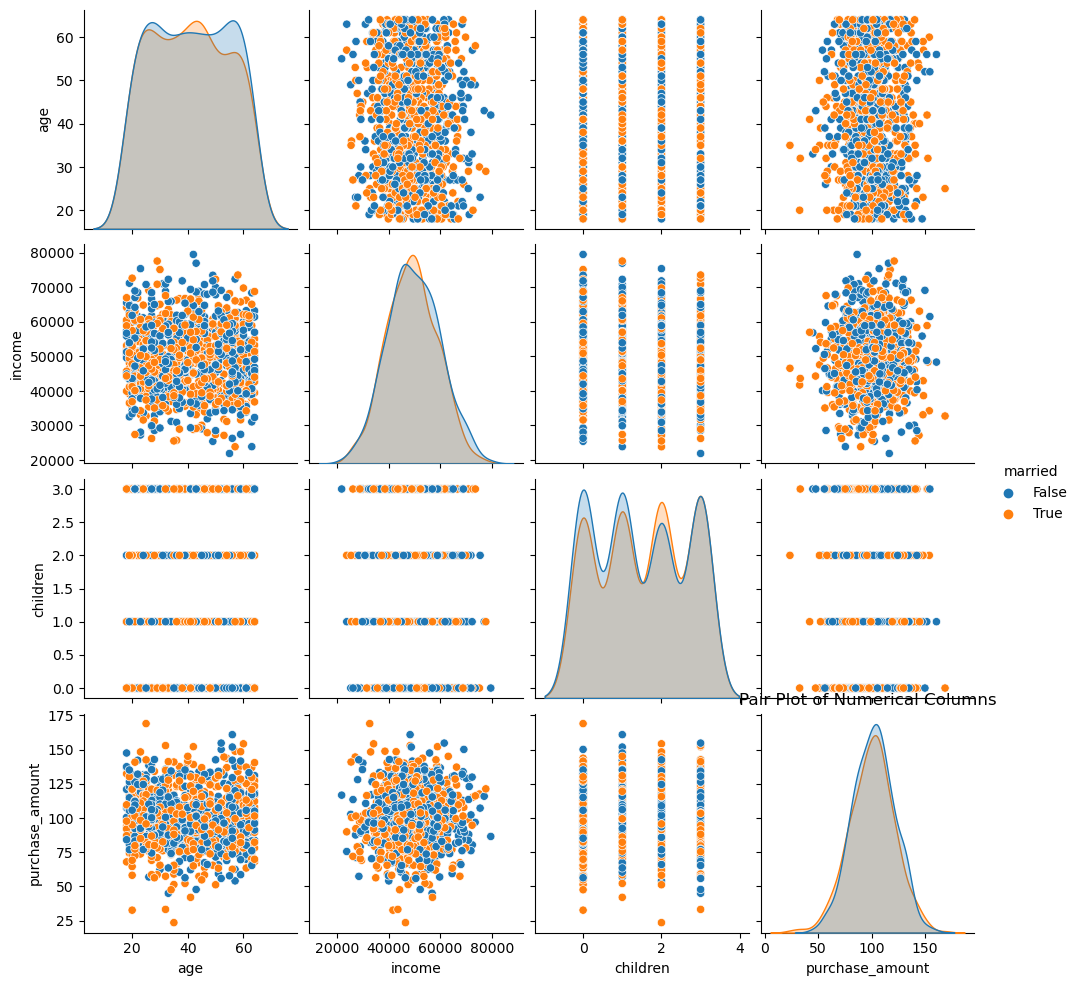

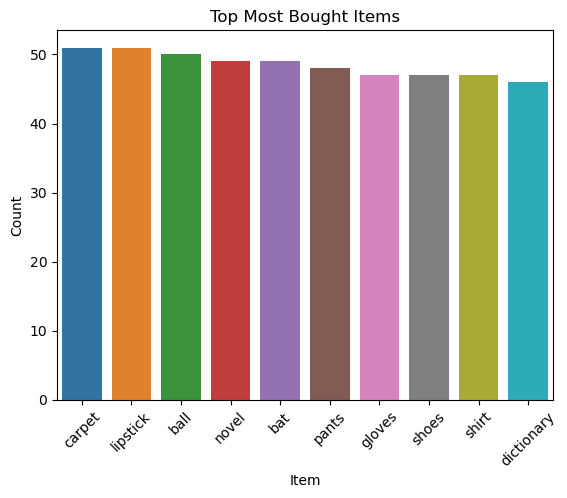

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# chat GPT
decision_tree_data = pd.read_csv('advertisement.csv')
# plt.figure(figsize=(4,3))
sns.countplot(data=decision_tree_data, x='gender')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

# plt.figure(figsize=(6,3))
sns.boxplot(data=decision_tree_data, x='education', y='income')
plt.title('Income by Education')
plt.xlabel('Education')
plt.ylabel('Income')
plt.xticks(rotation=45)
plt.show()


sns.pairplot(data=decision_tree_data, hue='married')
plt.title('Pair Plot of Numerical Columns')
plt.show()


# plt.figure(figsize=(12, 6))
top_items = decision_tree_data['most bought item'].value_counts().head(10)
sns.barplot(x=top_items.index, y=top_items.values)
plt.title('Top Most Bought Items')
plt.xlabel('Item')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# 3.3.1 - Decision Tree classes

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MultiLabelBinarizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, multilabel_confusion_matrix
class PowersetDecisionTree:
    def __init__(self,max_depth,max_features,criterion):    
        self.max_depth = max_depth
        self.max_features = max_features
        self.critrion = criterion
        self.tree = DecisionTreeClassifier(max_depth=max_depth,max_features=max_features,criterion=criterion)

    def train(self, train_x, train_y):
        self.tree.fit(train_x, train_y)

    def predict(self, test_x):
        return self.tree.predict(test_x)

    def performance_data(self, y_true, y_pred):
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred,average='micro',zero_division=1)
        recall = recall_score(y_true, y_pred,average='micro',zero_division=1)
        f1_macro = f1_score(y_true, y_pred,average='macro',zero_division=1)
        f1_micro = f1_score(y_true, y_pred,average='micro',zero_division=1)
        confustion_matrix = multilabel_confusion_matrix(y_true, y_pred)
        return accuracy*100, precision*100, recall*100, f1_macro*100, f1_micro*100, confustion_matrix

class MultiOutputDecisionTree:
    def __init__(self,max_depth,max_features,criterion):
        self.max_depth = max_depth
        self.max_features = max_features
        self.critrion = criterion
        self.tree = DecisionTreeClassifier(max_depth=max_depth,max_features=max_features,criterion=criterion)

    def train(self, train_x, train_y):
        self.tree.fit(train_x, train_y)

    def predict(self, test_x):
        return self.tree.predict(test_x)

    def performance_data(self, y_true, y_pred):
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred,average='micro',zero_division=1)
        recall = recall_score(y_true, y_pred,average='micro',zero_division=1)
        f1_macro = f1_score(y_true, y_pred,average='macro',zero_division=1)
        f1_micro = f1_score(y_true, y_pred,average='micro')
        confustion_matrix = multilabel_confusion_matrix(y_true, y_pred)
        return accuracy*100, precision*100, recall*100, f1_macro*100, f1_micro*100, confustion_matrix


In [123]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, OneHotEncoder

decision_tree_data = np.array(decision_tree_data)
#preprocessing
sorted_labels = [' '.join(sorted(labels)) for labels in [x.split(' ') for x in decision_tree_data[:,10]]]
decision_tree_data[:,10] = sorted_labels

# Convert to a DataFrame
columns = ['Age', 'Gender', 'Salary', 'Education', 'Married', 'Children', 'Location', 'Occupation', 'Expense', 'Purchase', 'Labels']
df = pd.DataFrame(decision_tree_data, columns=columns)

# Separate categorical and numerical features
categorical_cols = ['Gender', 'Education', 'Location', 'Occupation', 'Purchase']
numerical_cols = ['Age', 'Salary', 'Married', 'Children', 'Expense']
label = ['Labels']

# apply label encoding to categorical features
le = LabelEncoder()
X_categorical = np.array([le.fit_transform(df[col]) for col in categorical_cols]).T

# Apply one-hot encoding to labels features
ohe = OneHotEncoder(sparse_output=False) # sparse=False returns a numpy array instead of a sparse matrix, handle_unknown='ignore' ignores unknown categories in test data, drop='first' drops the first category in each feature to avoid multicollinearity
y = ohe.fit_transform(df[label])

X_numerical = df[numerical_cols].values

# Combine label encoded and numerical features
X = np.hstack((X_categorical, X_numerical))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

criterions = ["gini","entropy"]
max_features = [3,5,7,9,11]
max_depths = [3,5,10,20,30]
performance_report_powerset = []
for criter in criterions:
    for i in max_features:
        for depth in max_depths:
            decide = PowersetDecisionTree(criterion=criter,max_depth=depth,max_features=i)
            decide.train(X_train,y_train)
            y_pred = decide.predict(X_test)
            a = decide.performance_data(y_test,y_pred)
            a += (criter,i,depth)
            performance_report_powerset.append(a)

pd.DataFrame(performance_report_powerset, columns=["Accuracy", "Precision", "Recall", "F1-Score (macro)", "F1-Score (micro)", "Confusion Matrix","Criterion","Max Features","Max Depth"])


,Accuracy,Precision,Recall,F1-Score (macro),F1-Score (micro),Confusion Matrix,Criterion,Max Features,Max Depth
0,0.0,100.000000,0.0,45.544554,0.000000,"[[[196, 0], [4, 0]], [[195, 0], [5, 0]], [[200...",gini,3,3
1,0.5,11.111111,0.5,45.139514,0.956938,"[[[196, 0], [4, 0]], [[195, 0], [5, 0]], [[200...",gini,3,5
2,0.5,1.234568,0.5,53.712871,0.711744,"[[[196, 0], [4, 0]], [[195, 0], [5, 0]], [[200...",gini,3,10
3,1.5,1.500000,1.5,59.662120,1.500000,"[[[191, 5], [2, 2]], [[193, 2], [5, 0]], [[199...",gini,3,20
4,1.5,1.500000,1.5,62.004950,1.500000,"[[[189, 7], [4, 0]], [[192, 3], [5, 0]], [[199...",gini,3,30
5,0.0,0.000000,0.0,47.029703,100.000000,"[[[196, 0], [4, 0]], [[195, 0], [5, 0]], [[200...",gini,5,3
6,0.0,0.000000,0.0,46.534653,100.000000,"[[[196, 0], [4, 0]], [[195, 0], [5, 0]], [[200...",gini,5,5
7,0.5,1.219512,0.5,50.090009,0.709220,"[[[196, 0], [4, 0]], [[195, 0], [5, 0]], [[200...",gini,5,10
8,3.0,3.015075,3.0,60.752004,3.007519,"[[[195, 1], [4, 0]], [[190, 5], [5, 0]], [[198...",gini,5,20
9,3.5,3.500000,3.5,58.222023,3.500000,"[[[188, 8], [3, 1]], [[192, 3], [4, 1]], [[199...",gini,5,30


In [124]:
import seaborn as sns
performance_report_powerset = sorted(performance_report_powerset, key=lambda x: x[3], reverse=True)
performance_report_powerset = performance_report_powerset[:3]

# # plotting confusion matrix only for best triplet
# multilabel_conf_matrix = performance_report_powerset[0][5]
# num_labels = multilabel_conf_matrix.shape[0]
# # Create a subplot grid
# fig, axes = plt.subplots(nrows=1, ncols=num_labels, figsize=(15, 5))

# # Loop through each label's confusion matrix and create a heatmap
# for label_index, ax in enumerate(axes):
#     conf_matrix = multilabel_conf_matrix[label_index]
#     sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
#                 ax=ax, xticklabels=['Negative', 'Positive'],
#                 yticklabels=['Negative', 'Positive'])
#     # ax.set_title("Label - ",label_index)
#     ax.set_xlabel('Predicted')
#     ax.set_ylabel('True')

# plt.tight_layout()
# plt.show()

print("Top - 3:")
# delete 4th and 5th element from every row
performance_report_powerset = [x[:4] + x[6:] for x in performance_report_powerset]
best_criterion = performance_report_powerset[0][4]
best_max_features = performance_report_powerset[0][5]
best_max_depth = performance_report_powerset[0][6]
pd.DataFrame(performance_report_powerset, columns=["Accuracy", "Precision", "Recall", "F1-Score (macro)","Criterion","Max Features","Max Depth"])

Top - 3:


,Accuracy,Precision,Recall,F1-Score (macro),Criterion,Max Features,Max Depth
0,2.5,2.5,2.5,63.566714,entropy,9,20
1,2.0,2.0,2.0,63.486502,entropy,11,20
2,3.0,3.0,3.0,63.480277,gini,9,20


In [129]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
# Choose the number of folds (K)
k_folds = 5

# Initialize KFold cross-validator
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Initialize a Decision Tree classifier
pdt = PowersetDecisionTree(criterion=best_criterion, max_depth=best_max_depth, max_features=best_max_features) 

# Lists to store accuracy scores for each fold
accuracy_scores = []
precision_scores = []

# Perform K-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Train the classifier on the training data
    pdt.train(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = pdt.predict(X_test)
    
    # Calculate accuracy and precision scores for this fold
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    precision = precision_score(y_test, y_pred,average='macro',zero_division=1)
    precision_scores.append(precision)

# Calculate average accuracy
avg_accuracy = np.mean(accuracy_scores)
avg_prediction = np.mean(precision_scores)
print(f"Average Accuracy: ",avg_accuracy*100,"%")
print(f"Average Precision: ",avg_prediction*100,"%")

Average Accuracy:  2.4 %
Average Precision:  52.02746346063177 %


# Multi-Output

In [130]:

import seaborn as sns

# convert labels to binary vectors 
labels = df['Labels'].apply(lambda x: x.split())
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(labels)
print(y.shape)
X_numerical = df[numerical_cols].values

# Combine label encoded and numerical features
X = np.hstack((X_categorical, X_numerical))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

criterions = ["gini","entropy"]
max_features = [3,5,7,9,11]
max_depths = [3,5,10,20,30]
performance_report_multioutput = []
for criter in criterions:
    for i in max_features:
        for depth in max_depths:
            decide = MultiOutputDecisionTree(criterion=criter,max_depth=depth,max_features=i)
            decide.train(X_train,y_train)
            y_pred = decide.predict(X_test)
            a = decide.performance_data(y_test,y_pred)
            a += (criter,i,depth)
            performance_report_multioutput.append(a)

pd.DataFrame(performance_report_multioutput, columns=["Accuracy", "Precision", "Recall", "F1-Score (macro)", "F1-Score (micro)", "Confusion Matrix","Criterion","Max Features","Max Depth"])


(1000, 8)


,Accuracy,Precision,Recall,F1-Score (macro),F1-Score (micro),Confusion Matrix,Criterion,Max Features,Max Depth
0,2.5,57.692308,2.857143,17.217130,5.444646,"[[[132, 3], [64, 1]], [[129, 4], [67, 0]], [[1...",gini,3,3
1,2.0,40.425532,7.238095,23.794949,12.277868,"[[[120, 15], [59, 6]], [[114, 19], [59, 8]], [...",gini,3,5
2,2.0,38.283063,31.428571,34.240699,34.518828,"[[[92, 43], [46, 19]], [[95, 38], [42, 25]], [...",gini,3,10
3,2.0,38.860104,42.857143,40.715427,40.760870,"[[[93, 42], [37, 28]], [[83, 50], [42, 25]], [...",gini,3,20
4,2.5,40.585009,42.285714,41.312635,41.417910,"[[[90, 45], [40, 25]], [[94, 39], [41, 26]], [...",gini,3,30
5,3.5,100.000000,3.809524,5.681818,7.339450,"[[[135, 0], [65, 0]], [[133, 0], [67, 0]], [[1...",gini,5,3
6,5.5,85.714286,11.428571,43.061137,20.168067,"[[[135, 0], [65, 0]], [[129, 4], [67, 0]], [[1...",gini,5,5
7,3.5,49.714286,33.142857,39.776647,39.771429,"[[[107, 28], [51, 14]], [[101, 32], [44, 23]],...",gini,5,10
8,5.0,38.898451,43.047619,41.015541,40.867993,"[[[82, 53], [41, 24]], [[87, 46], [39, 28]], [...",gini,5,20
9,3.5,43.493761,46.476190,44.708576,44.935543,"[[[83, 52], [33, 32]], [[103, 30], [42, 25]], ...",gini,5,30


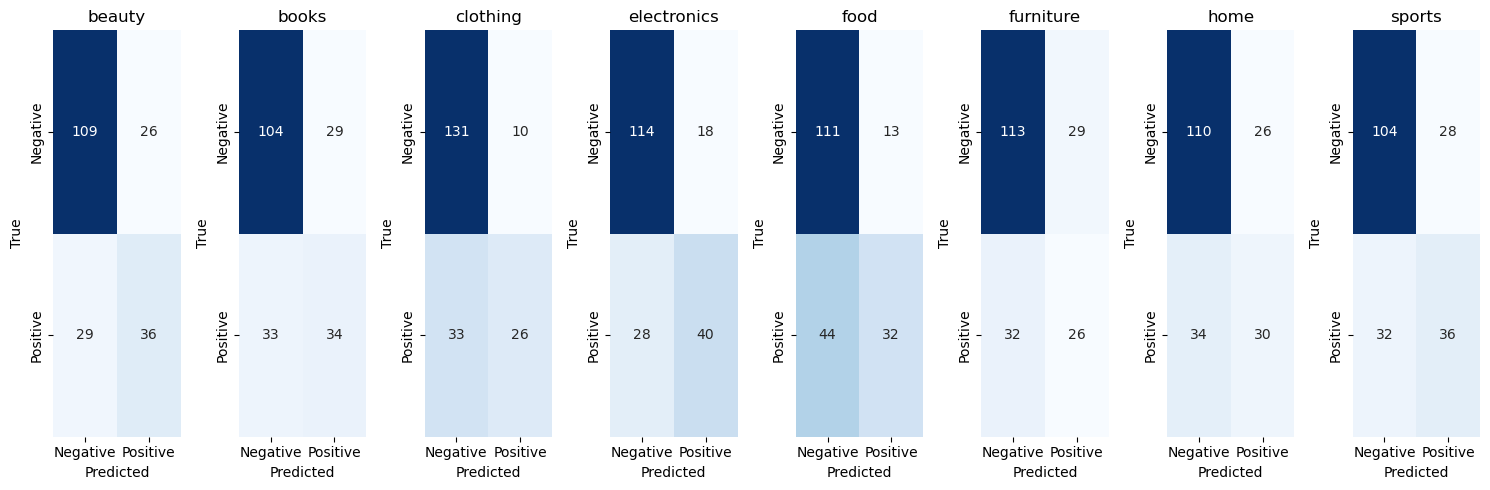

Top - 3:


,Accuracy,Precision,Recall,F1-Score (macro),Criterion,Max Features,Max Depth
0,7.5,59.225513,49.523810,53.835653,gini,11,10
1,3.5,51.052632,55.428571,53.084443,entropy,9,20
2,6.0,58.101852,47.809524,52.392918,gini,7,10


In [131]:
performance_report_multioutput = sorted(performance_report_multioutput, key=lambda x: x[3], reverse=True)
performance_report_multioutput = performance_report_multioutput[:3]

# plotting confusion matrix only for best triplet
multilabel_conf_matrix = performance_report_multioutput[0][5]

# Create a subplot grid
fig, axes = plt.subplots(nrows=1, ncols=len(mlb.classes_), figsize=(15, 5))

# Loop through each label's confusion matrix and create a heatmap
for label_index, ax in enumerate(axes):
    conf_matrix = multilabel_conf_matrix[label_index]
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                ax=ax, xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    ax.set_title(mlb.classes_[label_index])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout()
plt.show()

# top-3
print("Top - 3:")
# delete 4th and 5th element from every row
performance_report_multioutput = [x[:4] + x[6:] for x in performance_report_multioutput]
best_criterion = performance_report_multioutput[0][4]
best_max_features = performance_report_multioutput[0][5]
best_max_depth = performance_report_multioutput[0][6]

pd.DataFrame(performance_report_multioutput, columns=["Accuracy", "Precision", "Recall", "F1-Score (macro)","Criterion","Max Features","Max Depth"])

In [132]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report


# # Convert to a DataFrame
# columns = ['Age', 'Gender', 'Salary', 'Education', 'Married', 'Children', 'Location', 'Occupation', 'Expense', 'Purchase', 'Labels']
# df = pd.DataFrame(decision_tree_data, columns=columns)

# # Separate categorical and numerical features
# categorical_cols = ['Gender', 'Education', 'Location', 'Occupation', 'Purchase']
# numerical_cols = ['Age', 'Salary', 'Married', 'Children', 'Expense']

# # Apply LabelEncoder to categorical features
# label_encoders = {}
# for col in categorical_cols:
#     le = LabelEncoder()
#     df[col] = le.fit_transform(df[col])
#     label_encoders[col] = le

# # Standardize numerical features
# scaler = StandardScaler()
# X_numerical = scaler.fit_transform(df[numerical_cols])

# # Combine encoded categorical and numerical features
# X = np.hstack((df[categorical_cols], X_numerical))

# Extract and split labels
labels = df['Labels'].apply(lambda x: x.split())
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(labels)

# Choose the number of folds (K)
k_folds = 5

# Initialize KFold cross-validator
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Initialize a Decision Tree classifier
modt = MultiOutputDecisionTree(criterion=best_criterion, max_depth=best_max_depth, max_features=best_max_features) 

# Lists to store accuracy scores and classification reports for each fold
accuracy_scores = []
classification_reports = []

# Perform K-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Train the classifier on the training data
    modt.train(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = modt.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    
    # Append classification report to the list
    class_report = classification_report(y_test, y_pred, target_names=mlb.classes_, output_dict=True)
    classification_reports.append(class_report)

# Calculate average accuracy
avg_accuracy = np.mean(accuracy_scores)
print(f"Average Accuracy: {avg_accuracy*100:.2f} %")

# Print average classification report
average_report = {}
for class_name in mlb.classes_:
    avg_report = {
        'precision': np.mean([cr[class_name]['precision'] for cr in classification_reports]),
        'recall': np.mean([cr[class_name]['recall'] for cr in classification_reports]),
        'f1-score': np.mean([cr[class_name]['f1-score'] for cr in classification_reports]),
    }
    average_report[class_name] = avg_report

# Print average classification report
print("="*30)
print("Average Classification Report:")
for class_name in mlb.classes_:
    print(f"Class: {class_name}")
    print(f"Precision: {average_report[class_name]['precision']*100:.2f} %")
    print(f"Recall: {average_report[class_name]['recall']*100:.2f} %")
    print(f"F1-score: {average_report[class_name]['f1-score']*100:.2f} %")
    print("="*30)

Average Accuracy: 6.30 %
Average Classification Report:
Class: beauty
Precision: 61.53 %
Recall: 47.86 %
F1-score: 53.80 %
Class: books
Precision: 61.53 %
Recall: 48.68 %
F1-score: 54.33 %
Class: clothing
Precision: 63.14 %
Recall: 51.38 %
F1-score: 56.58 %
Class: electronics
Precision: 59.94 %
Recall: 45.45 %
F1-score: 51.57 %
Class: food
Precision: 55.77 %
Recall: 41.27 %
F1-score: 47.23 %
Class: furniture
Precision: 58.35 %
Recall: 43.13 %
F1-score: 49.36 %
Class: home
Precision: 55.50 %
Recall: 43.69 %
F1-score: 48.52 %
Class: sports
Precision: 61.90 %
Recall: 46.40 %
F1-score: 52.80 %
